# Imports and Defaults

In [1]:
import os
import sys
sys.path.append(os.path.abspath('../../src'))

import numpy as np
import polars as pl
import scipy.stats as stats
import seaborn as sns

from utils.posteriors import processed_ref_draws

In [2]:
sns.set_theme(style="darkgrid")
experiment = "funnel10"
num_params = 10
data_dir = os.path.join("..", "..", "data", experiment)

# Load Dataframe

In [3]:
path = os.path.join(data_dir, "summary.parquet")
summary = pl.read_parquet(path)
summary.head()

chain,damping,max_proposals,metric,probabilistic,reduction_factor,sampler_type,step_count_method,step_size,step_size_factor,hparams,num_nans,max_se1,max_se2,p0_se1,p1_se1,p2_se1,p3_se1,p4_se1,p5_se1,p6_se1,p7_se1,p8_se1,p9_se1,p0_se2,p1_se2,p2_se2,p3_se2,p4_se2,p5_se2,p6_se2,p7_se2,p8_se2,p9_se2,step_count,step_count_factor
i64,f64,i64,i64,bool,i64,str,str,null,f64,str,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,null,f64
3,0.05,2,1,false,2,"""drghmc""","""const_traj_len…",null,2.0,"""damping=0.05__…",0,0.842139,4507.67968,0.022614,0.055424,0.000896,0.005447,0.001147,0.157834,0.842139,0.027987,0.002816,0.149218,0.259536,1871.817046,2596.811154,1341.822566,1085.002806,1167.722381,97.281071,684.990203,1996.451306,4507.67968,null,null
0,1.0,2,1,false,8,"""drhmc""",null,null,5.0,"""damping=1__max…",162161,0.175739,5521.113183,0.03871,0.006442,0.034654,0.000141,0.001789,0.00027,0.07416,0.175739,0.012172,0.00062,0.064859,1860.007063,3061.88395,2231.92535,2767.418743,2511.637898,1251.134843,1532.122139,3613.589875,5521.113183,null,0.9
3,0.1,4,1,false,2,"""drghmc""","""const_traj_len…",null,2.0,"""damping=0.1__m…",296347616,0.120111,5993.458903,0.013703,0.06623,0.120111,0.014542,0.006528,0.001053,0.068237,0.008106,0.073416,0.096369,1.018732,2412.780494,3345.428151,1915.175999,3651.435449,4148.079934,1723.285381,2733.789233,5139.060004,5993.458903,null,null
1,0.05,4,1,false,2,"""drghmc""","""const_step_cou…",null,1.0,"""damping=0.05__…",0,0.308863,4607.407115,0.019998,0.108424,0.062431,0.068761,0.031782,0.075371,0.004438,0.113198,0.308863,0.00379,1.580627,2490.215103,3480.065742,2001.425783,1506.424235,1543.666415,1489.664676,2114.538749,2606.531944,4607.407115,null,null
0,0.1,4,1,false,16,"""drghmc""","""const_step_cou…",null,0.5,"""damping=0.1__m…",0,0.25939,9795.864711,0.253327,0.032961,0.038128,0.25939,0.028526,0.031738,0.077075,0.002006,0.007682,0.044768,12.492596,4638.222407,6285.102983,4514.031089,5165.402744,5616.500821,3987.881973,4267.826048,6793.32843,9795.864711,null,null


# Max Squared Error

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Max Squared Error Per Chain')

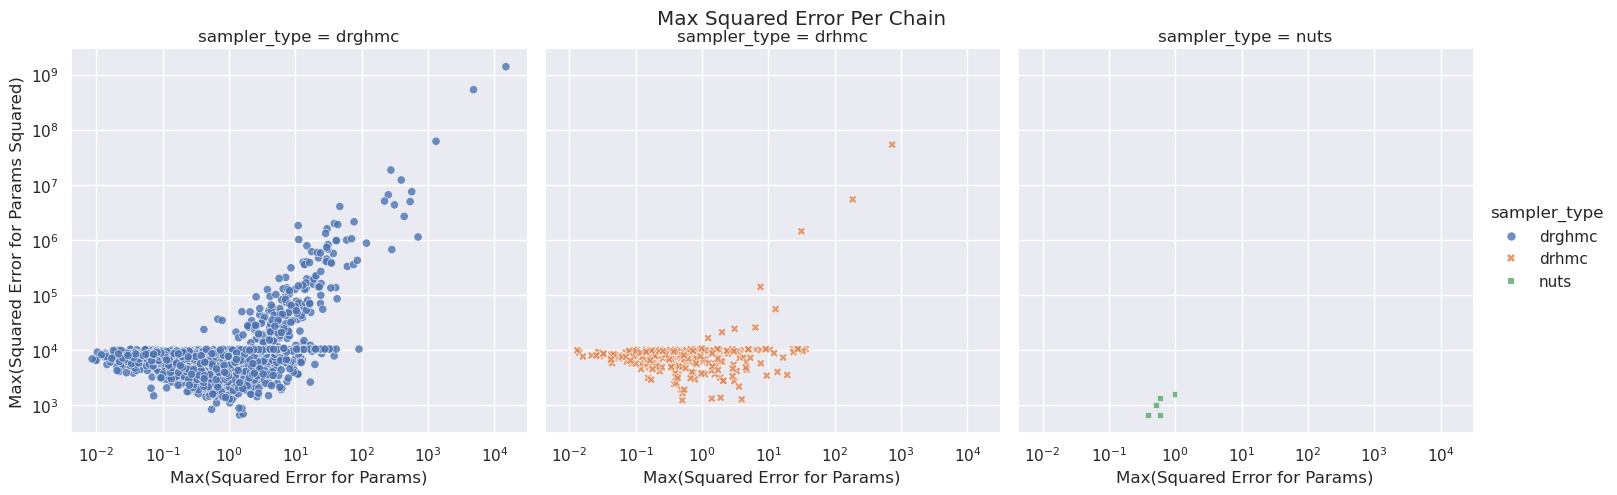

In [5]:
fig = sns.relplot(
    data=summary.to_pandas(),
    kind="scatter",
    x="max_se1",
    y="max_se2",
    hue="sampler_type",
    style="sampler_type",
    alpha=0.8,
    col="sampler_type",
    col_order=["drghmc", "drhmc", "nuts"]
)
# rename x axis and y axis
fig.set(xlabel="Max(Squared Error for Params)", ylabel="Max(Squared Error for Params Squared)")
fig.set(xscale="log", yscale="log")
fig.fig.subplots_adjust(top = 0.9)
fig.fig.suptitle("Max Squared Error Per Chain")

In [6]:
grouped = summary.group_by("hparams").agg([
    pl.col("max_se1").std().alias("se1_std"),
    pl.col("max_se2").std().alias("se2_std"),
    pl.col("max_se1").mean().alias("se1_mean"),
    pl.col("max_se2").mean().alias("se2_mean"),
    pl.col("sampler_type").first().alias("sampler_type"),
    #pl.col("step_count_method").first().alias("step_count_method"),
    pl.col("step_count_factor").first().alias("step_count_factor"),
    pl.col("max_proposals").first().alias("max_proposals"),
    pl.col("reduction_factor").first().alias("reduction_factor"),
    pl.col("damping").first().alias("damping"),
])

# make new Polars column for the max of se1_std and se2_std 
grouped = grouped.with_columns(
    pl.when(pl.col("se1_std") > pl.col("se2_std")).then(pl.col("se1_std")).otherwise(pl.col("se2_std")).alias("max_std")
)
grouped.describe()

statistic,hparams,se1_std,se2_std,se1_mean,se2_mean,sampler_type,step_count_factor,max_proposals,reduction_factor,damping,max_std
str,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64
"""count""","""881""",881.0,881.0,881.0,881.0,"""881""",80.0,880.0,880.0,880.0,881.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,"""0""",801.0,1.0,1.0,1.0,0.0
"""mean""",null,15.744127,1.1020e6,7.635495,500592.927888,null,0.9,3.5,7.5,0.265455,1.1020e6
"""std""",null,237.753058,2.2721e7,106.422327,1.0164e7,null,0.0,1.11867,5.364952,0.290944,2.2721e7
"""min""","""damping=0.01__…",0.014109,40.241488,0.06486,1056.718496,"""drghmc""",0.9,2.0,2.0,0.01,40.241488
"""25%""",null,0.218943,1072.657065,0.285505,6642.978453,null,0.9,3.0,4.0,0.05,1072.657065
"""50%""",null,0.597907,1886.977427,0.552136,7954.165998,null,0.9,4.0,8.0,0.1,1886.977427
"""75%""",null,2.667304,2886.71101,1.867229,9556.031893,null,0.9,4.0,8.0,0.5,2886.71101
"""max""","""sampler_type=n…",6665.013923,6.2919e8,2982.131062,2.8139e8,"""nuts""",0.9,5.0,16.0,1.0,6.2919e8


/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Max Squared Error Per Hyperparameter Setting')

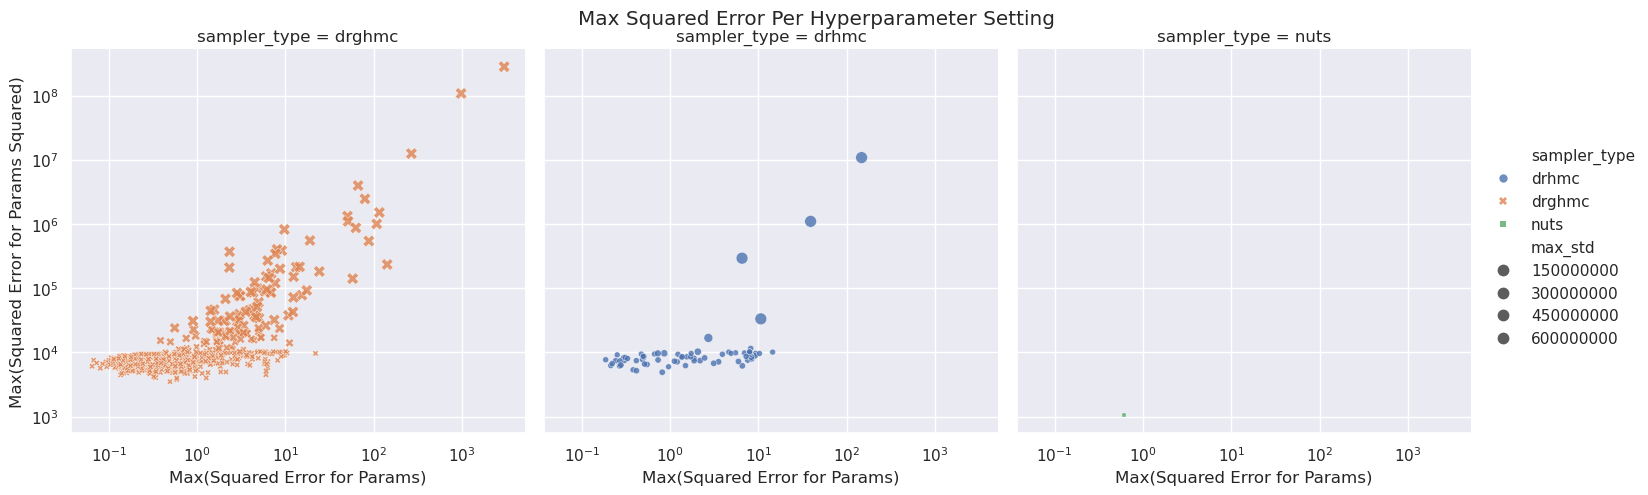

In [7]:
fig = sns.relplot(
    data=grouped.to_pandas(),
    kind="scatter",
    x="se1_mean",
    y="se2_mean",
    hue="sampler_type",
    style="sampler_type",
    alpha=0.8,
    col="sampler_type",
    col_order=["drghmc", "drhmc", "nuts"],
    size="max_std",
    size_norm=(500, 50000)
)
# rename x axis and y axis
fig.set(xlabel="Max(Squared Error for Params)", ylabel="Max(Squared Error for Params Squared)")
fig.set(xscale="log", yscale="log")
fig.fig.subplots_adjust(top = 0.9)
fig.fig.suptitle("Max Squared Error Per Hyperparameter Setting")

# Per-Parameter Squared Error

In [30]:
value_vars = [f"p{idx}_se1" for idx in range(num_params)] + [f"p{idx}_se2" for idx in range(num_params)]
id_vars = ["hparams", "sampler_type", "chain", "step_count_method", "step_count_factor", "max_proposals", "reduction_factor", "damping", "step_size_factor"]

melted = summary.melt(
    id_vars=id_vars,
    value_vars=value_vars, 
    variable_name="param_error", 
    value_name="squared error"
)

melted = melted.with_columns(
    pl.col("param_error")
    .str.split_exact(by="_", n=1)
    .struct.rename_fields(["param", "error_type"])
).unnest("param_error")

melted = melted.pivot(
    index=id_vars + ["param"],
    columns="error_type",
    values="squared error",
)

melted.head()    

hparams,sampler_type,chain,step_count_method,step_count_factor,max_proposals,reduction_factor,damping,step_size_factor,param,se1,se2
str,str,i64,str,f64,i64,i64,f64,f64,str,f64,f64
"""damping=0.05__…","""drghmc""",3,"""const_traj_len…",null,2,2,0.05,2.0,"""p0""",0.022614,0.259536
"""damping=1__max…","""drhmc""",0,null,0.9,2,8,1.0,5.0,"""p0""",0.03871,0.064859
"""damping=0.1__m…","""drghmc""",3,"""const_traj_len…",null,4,2,0.1,2.0,"""p0""",0.013703,1.018732
"""damping=0.05__…","""drghmc""",1,"""const_step_cou…",null,4,2,0.05,1.0,"""p0""",0.019998,1.580627
"""damping=0.1__m…","""drghmc""",0,"""const_step_cou…",null,4,16,0.1,0.5,"""p0""",0.253327,12.492596


In [31]:
melted = melted.filter(pl.col("param").str.contains("p[0-2]"))
melted.head()

hparams,sampler_type,chain,step_count_method,step_count_factor,max_proposals,reduction_factor,damping,step_size_factor,param,se1,se2
str,str,i64,str,f64,i64,i64,f64,f64,str,f64,f64
"""damping=0.05__…","""drghmc""",3,"""const_traj_len…",null,2,2,0.05,2.0,"""p0""",0.022614,0.259536
"""damping=1__max…","""drhmc""",0,null,0.9,2,8,1.0,5.0,"""p0""",0.03871,0.064859
"""damping=0.1__m…","""drghmc""",3,"""const_traj_len…",null,4,2,0.1,2.0,"""p0""",0.013703,1.018732
"""damping=0.05__…","""drghmc""",1,"""const_step_cou…",null,4,2,0.05,1.0,"""p0""",0.019998,1.580627
"""damping=0.1__m…","""drghmc""",0,"""const_step_cou…",null,4,16,0.1,0.5,"""p0""",0.253327,12.492596


/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Squared Error Per Chain')

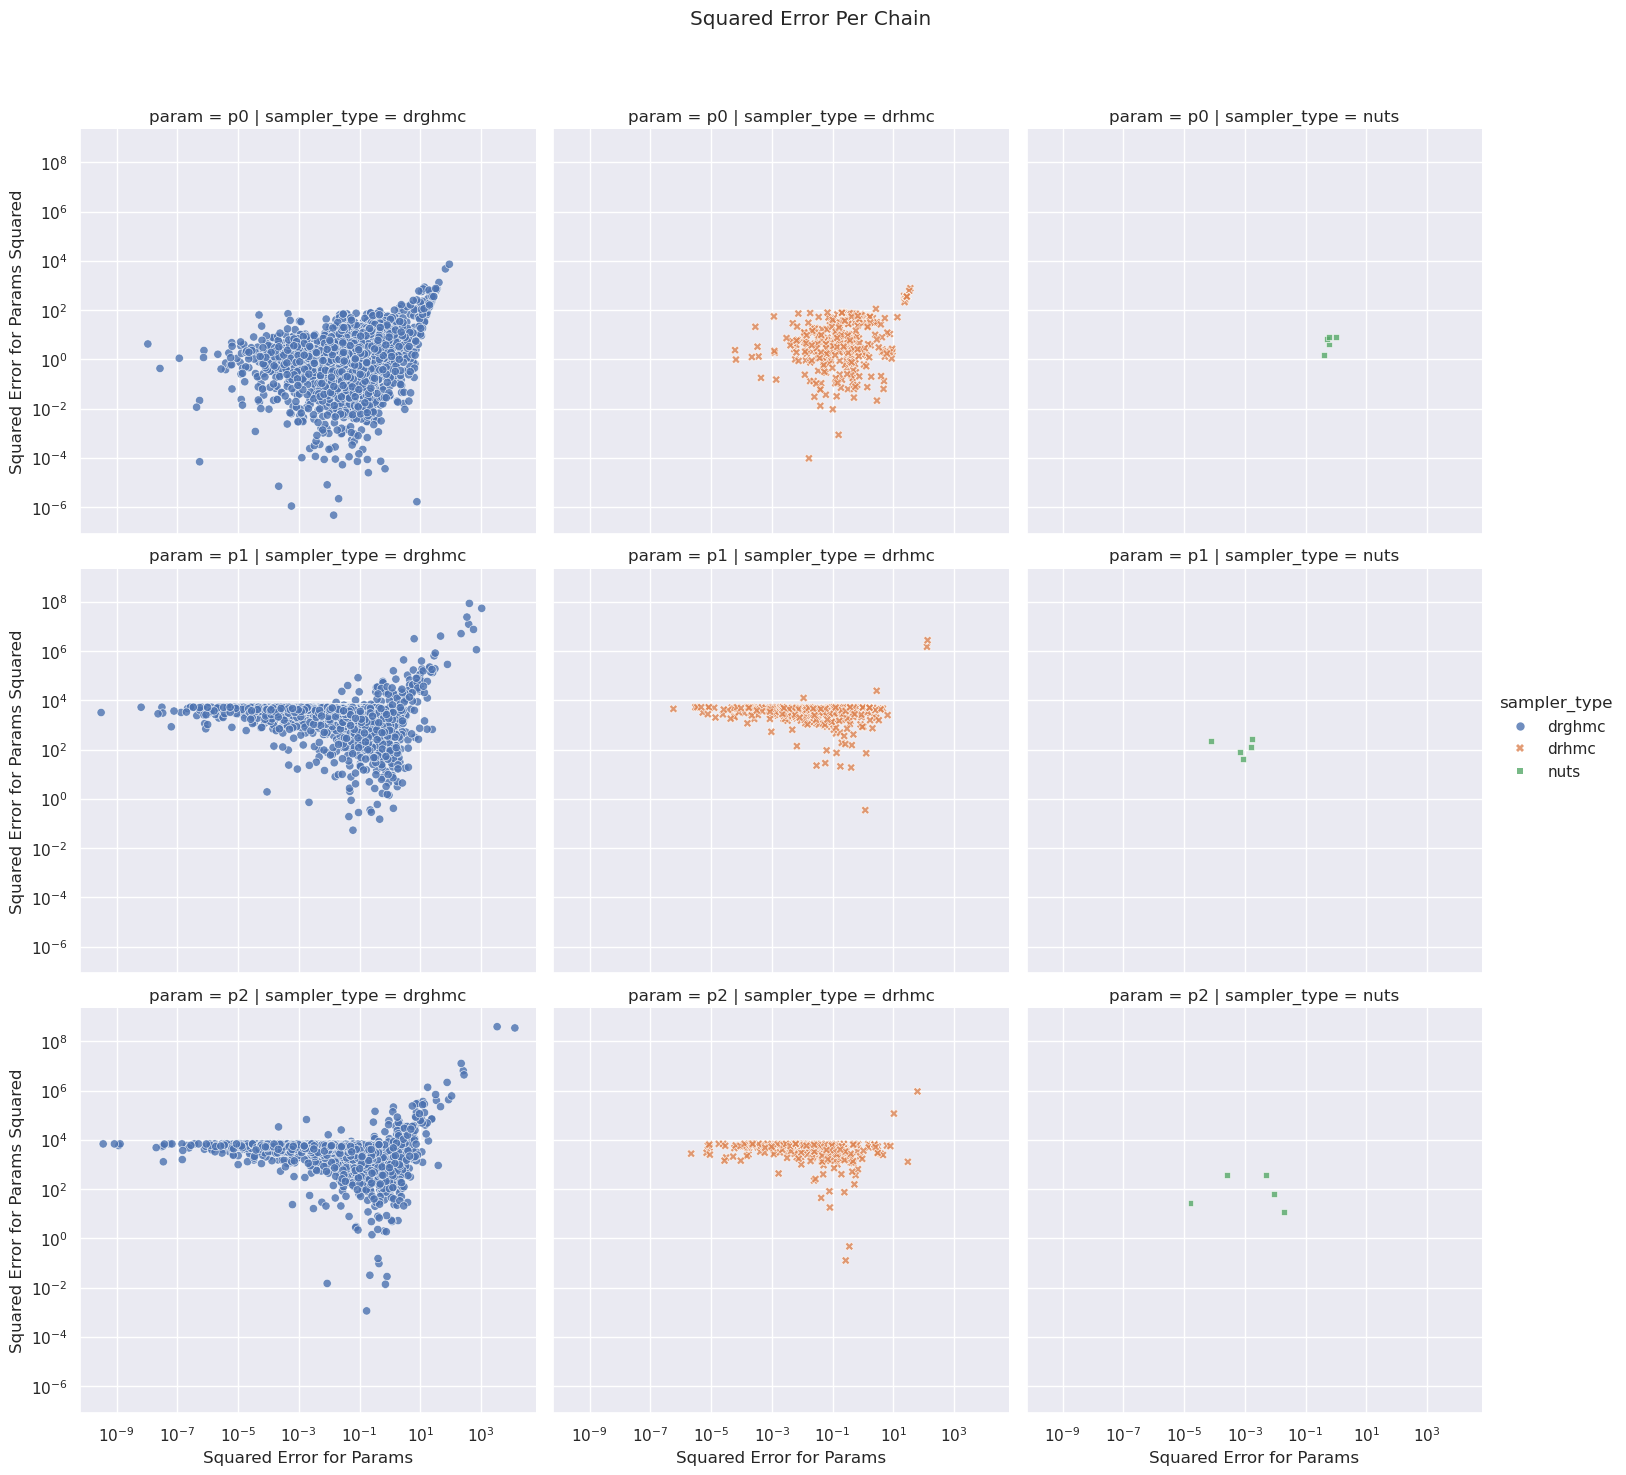

In [32]:
fig = sns.relplot(
    data=melted.to_pandas(),
    kind="scatter",
    x="se1",
    y="se2",
    hue="sampler_type",
    style="sampler_type",
    alpha=0.8,
    row="param",
    row_order=["p0", "p1", "p2"],
    col="sampler_type",
    col_order=["drghmc", "drhmc", "nuts"]
)
# rename x axis and y axis
fig.set(xlabel="Squared Error for Params", ylabel="Squared Error for Params Squared")
fig.set(xscale="log", yscale="log")
fig.fig.subplots_adjust(top = 0.9)
fig.fig.suptitle("Squared Error Per Chain")

In [33]:
melted_group = melted.group_by("param", "hparams").agg([
    pl.col("se1").std().alias("se1_std"),
    pl.col("se2").std().alias("se2_std"),
    pl.col("se1").mean().alias("se1_mean"),
    pl.col("se2").mean().alias("se2_mean"),
    pl.col("sampler_type").first().alias("sampler_type"),
    pl.col("step_count_method").first().alias("step_count_method"),
    pl.col("step_count_factor").first().alias("step_count_factor"),
    pl.col("step_size_factor").first().alias("step_size_factor"),
    pl.col("max_proposals").first().alias("max_proposals"),
    pl.col("reduction_factor").first().alias("reduction_factor"),
    pl.col("damping").first().alias("damping"),
])

# make new Polars column for the max of se1_std and se2_std 
melted_group = melted_group.with_columns(
    pl.when(pl.col("se1_std") > pl.col("se2_std")).then(pl.col("se1_std")).otherwise(pl.col("se2_std")).alias("max_std")
)
melted_group.describe()

statistic,param,hparams,se1_std,se2_std,se1_mean,se2_mean,sampler_type,step_count_method,step_count_factor,step_size_factor,max_proposals,reduction_factor,damping,max_std
str,str,str,f64,f64,f64,f64,str,str,f64,f64,f64,f64,f64,f64
"""count""","""2643""","""2643""",2643.0,2643.0,2643.0,2643.0,"""2643""","""2400""",240.0,2640.0,2640.0,2640.0,2640.0,2643.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,"""0""","""243""",2403.0,3.0,3.0,3.0,3.0,0.0
"""mean""",null,null,4.432631,167222.681761,2.101575,77028.020338,null,null,0.9,3.3,3.5,7.5,0.265455,167222.681925
"""std""",null,null,117.916046,4.6640e6,52.74959,2.0869e6,null,null,1.1125e-16,2.821882,1.118246,5.362918,0.290833,4.6640e6
"""min""","""p0""","""damping=0.01__…",0.000671,0.137424,0.000958,0.190544,"""drghmc""","""const_step_cou…",0.9,0.5,2.0,2.0,0.01,0.147377
"""25%""",null,null,0.045591,7.48413,0.039655,7.719854,null,null,0.9,1.0,3.0,4.0,0.05,7.48413
"""50%""",null,null,0.111189,779.262144,0.097717,2934.778117,null,null,0.9,2.0,4.0,8.0,0.1,779.262144
"""75%""",null,null,0.419538,1576.052053,0.280441,4323.437974,null,null,0.9,5.0,4.0,8.0,0.5,1576.052053
"""max""","""p2""","""sampler_type=n…",5824.899794,1.7563e8,2605.040605,7.8621e7,"""nuts""","""const_traj_len…",0.9,8.0,5.0,16.0,1.0,1.7563e8


/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Squared Error Per Hyperparameter Configuration: Step Count Factor')

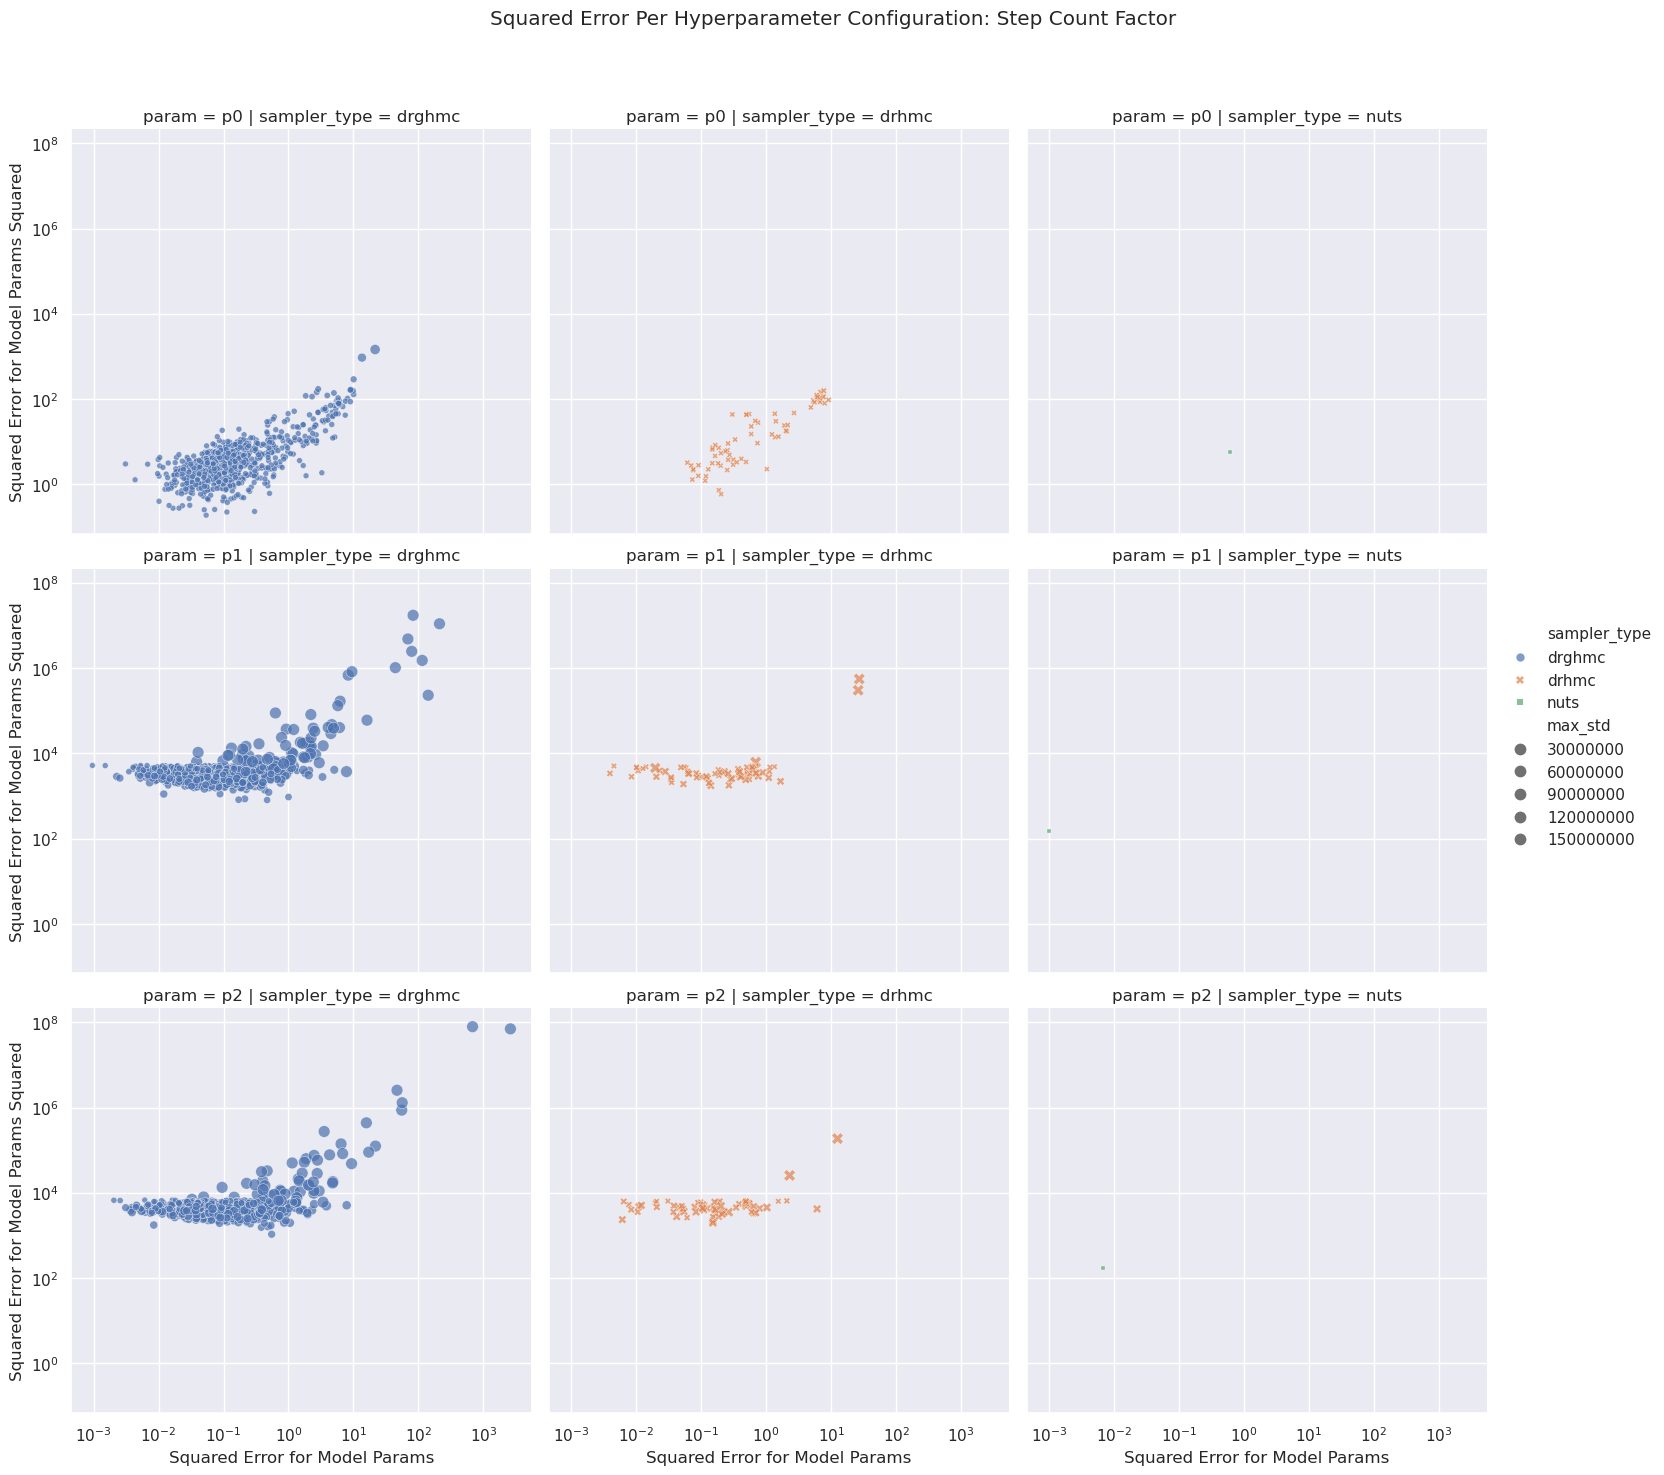

In [36]:
fig = sns.relplot(
    data=melted_group.to_pandas(),
    kind="scatter",
    x="se1_mean",
    y="se2_mean",
    hue="sampler_type",
    style="sampler_type",
    alpha=0.7,
    col="sampler_type",
    col_order=["drghmc", "drhmc", "nuts"],
    row="param",
    row_order=["p0", "p1", "p2"],
    size="max_std",
    size_norm=(1, 5000)
)
# rename x axis and y axis
fig.set(xlabel="Squared Error for Model Params", ylabel="Squared Error for Model Params Squared")
fig.set(xscale="log", yscale="log")
fig.fig.subplots_adjust(top = 0.9)
fig.fig.suptitle("Squared Error Per Hyperparameter Configuration: Step Count Factor")

# Max Relative Squared Error

In [19]:
fig = sns.relplot(
    data=summary.to_pandas(),
    kind="scatter",
    x="max_rse1",
    y="max_rse2",
    hue="sampler_type",
    style="sampler_type",
    alpha=0.8,
    col="sampler_type",
    col_order=["drghmc", "drhmc", "nuts"]
)
# rename x axis and y axis
fig.set(xlabel="Max(Relative Squared Error for Params)", ylabel="Max(Relative Squared Error for Params Squared)")
fig.set(xscale="log", yscale="log")
fig.fig.subplots_adjust(top = 0.9)
fig.fig.suptitle("Max Relative Squared Error Per Chain")

ValueError: Could not interpret value `max_rse1` for `x`. An entry with this name does not appear in `data`.

In [160]:
grouped = summary.group_by("hparams").agg([
    pl.col("max_rse1").std().alias("rse1_std"),
    pl.col("max_rse2").std().alias("rse2_std"),
    pl.col("max_rse1").mean().alias("rse1_mean"),
    pl.col("max_rse2").mean().alias("rse2_mean"),
    pl.col("sampler_type").first().alias("sampler_type"),
    #pl.col("step_count_method").first().alias("step_count_method"),
    pl.col("step_count_factor").first().alias("step_count_factor"),
    pl.col("max_proposals").first().alias("max_proposals"),
    pl.col("reduction_factor").first().alias("reduction_factor"),
    pl.col("damping").first().alias("damping"),
])

# make new Polars column for the max of se1_std and se2_std 
grouped = grouped.with_columns(
    pl.when(pl.col("rse1_std") > pl.col("rse2_std")).then(pl.col("rse1_std")).otherwise(pl.col("rse2_std")).alias("max_std")
)
grouped.describe()

statistic,hparams,rse1_std,rse2_std,rse1_mean,rse2_mean,sampler_type,step_count_factor,max_proposals,reduction_factor,damping,max_std
str,str,f64,f64,f64,f64,str,f64,f64,f64,f64,f64
"""count""","""881""",881.0,881.0,881.0,881.0,"""881""",80.0,880.0,880.0,880.0,881.0
"""null_count""","""0""",0.0,0.0,0.0,0.0,"""0""",801.0,1.0,1.0,1.0,0.0
"""mean""",null,2.3533e6,42.390695,1.0866e6,19.8892,null,0.9,3.5,7.5,0.265455,2.3533e6
"""std""",null,1.1324e7,542.611047,5.0817e6,242.721745,null,0.0,1.11867,5.364952,0.290944,1.1324e7
"""min""","""damping=0.01__…",806.06451,0.018384,925.595347,0.383764,"""drghmc""",0.9,2.0,2.0,0.01,806.06451
"""25%""",null,26649.136042,0.114206,21069.858693,0.687867,null,0.9,3.0,4.0,0.05,26649.136042
"""50%""",null,93534.797934,0.202493,65304.480237,0.838698,null,0.9,4.0,8.0,0.1,93534.797934
"""75%""",null,472743.42444,3.128401,261748.525321,2.246933,null,0.9,4.0,8.0,0.5,472743.42444
"""max""","""sampler_type=n…",2.1885e8,15534.277543,9.7929e7,6947.683202,"""nuts""",0.9,5.0,16.0,1.0,2.1885e8


/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Max Relative Squared Error Per Hyperparameter Setting')

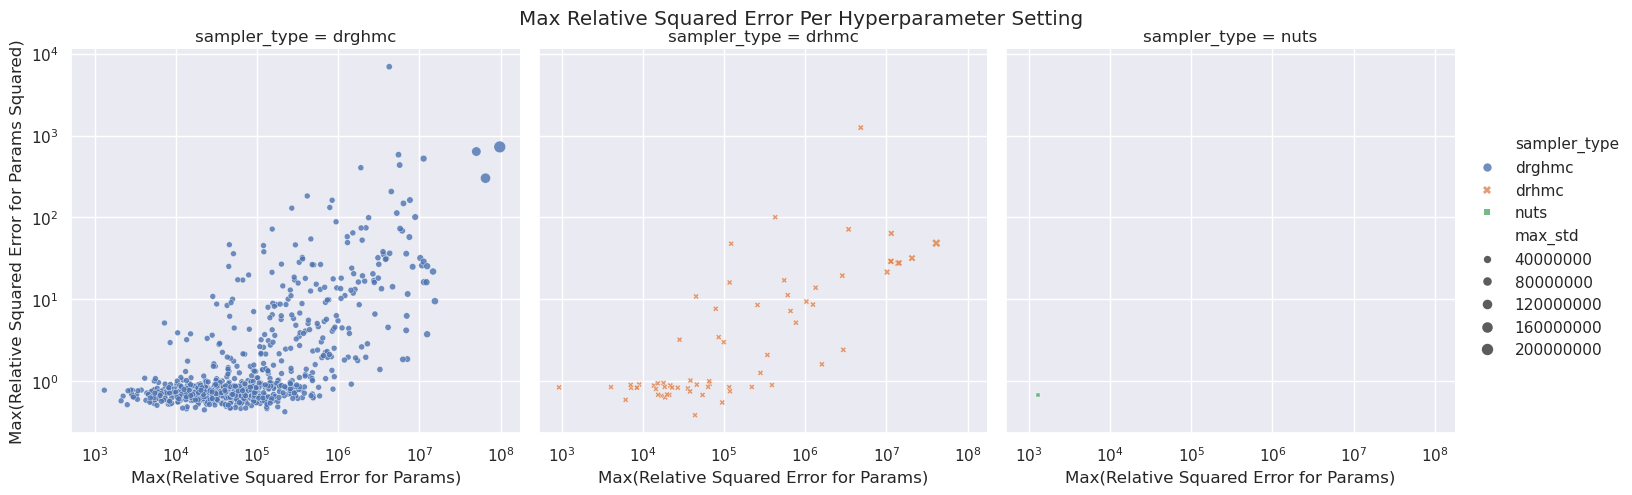

In [161]:
fig = sns.relplot(
    data=grouped.to_pandas(),
    kind="scatter",
    x="rse1_mean",
    y="rse2_mean",
    hue="sampler_type",
    style="sampler_type",
    alpha=0.8,
    col="sampler_type",
    col_order=["drghmc", "drhmc", "nuts"],
    size="max_std",
)
# rename x axis and y axis
fig.set(xlabel="Max(Relative Squared Error for Params)", ylabel="Max(Relative Squared Error for Params Squared)")
fig.set(xscale="log", yscale="log")
fig.fig.subplots_adjust(top = 0.9)
fig.fig.suptitle("Max Relative Squared Error Per Hyperparameter Setting")

# Relative Squared Error Per Parameter

In [162]:
value_vars = [f"p{idx}_rse1" for idx in range(num_params)] + [f"p{idx}_rse2" for idx in range(num_params)]
id_vars = ["hparams", "sampler_type", "chain"]

melted = summary.melt(
    id_vars=id_vars,
    value_vars=value_vars, 
    variable_name="param_error", 
    value_name="squared error"
)

melted = melted.with_columns(
    pl.col("param_error")
    .str.split_exact(by="_", n=1)
    .struct.rename_fields(["param", "error_type"])
).unnest("param_error")

melted = melted.pivot(
    index=id_vars + ["param"],
    columns="error_type",
    values="squared error",
)

melted.head()    

hparams,sampler_type,chain,param,rse1,rse2
str,str,i64,str,f64,f64
"""damping=0.05__…","""drghmc""",3,"""p0""",1.197252,0.005628
"""damping=1__max…","""drhmc""",0,"""p0""",14.789819,0.002037
"""damping=0.1__m…","""drghmc""",3,"""p0""",0.062017,0.01578
"""damping=0.05__…","""drghmc""",1,"""p0""",0.051933,0.033208
"""damping=0.1__m…","""drghmc""",0,"""p0""",11.304144,0.08872


In [163]:
melted = melted.filter(pl.col("param").str.contains("p[0-1]"))
melted.head()

hparams,sampler_type,chain,param,rse1,rse2
str,str,i64,str,f64,f64
"""damping=0.05__…","""drghmc""",3,"""p0""",1.197252,0.005628
"""damping=1__max…","""drhmc""",0,"""p0""",14.789819,0.002037
"""damping=0.1__m…","""drghmc""",3,"""p0""",0.062017,0.01578
"""damping=0.05__…","""drghmc""",1,"""p0""",0.051933,0.033208
"""damping=0.1__m…","""drghmc""",0,"""p0""",11.304144,0.08872


/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Relative Squared Error Per Chain')

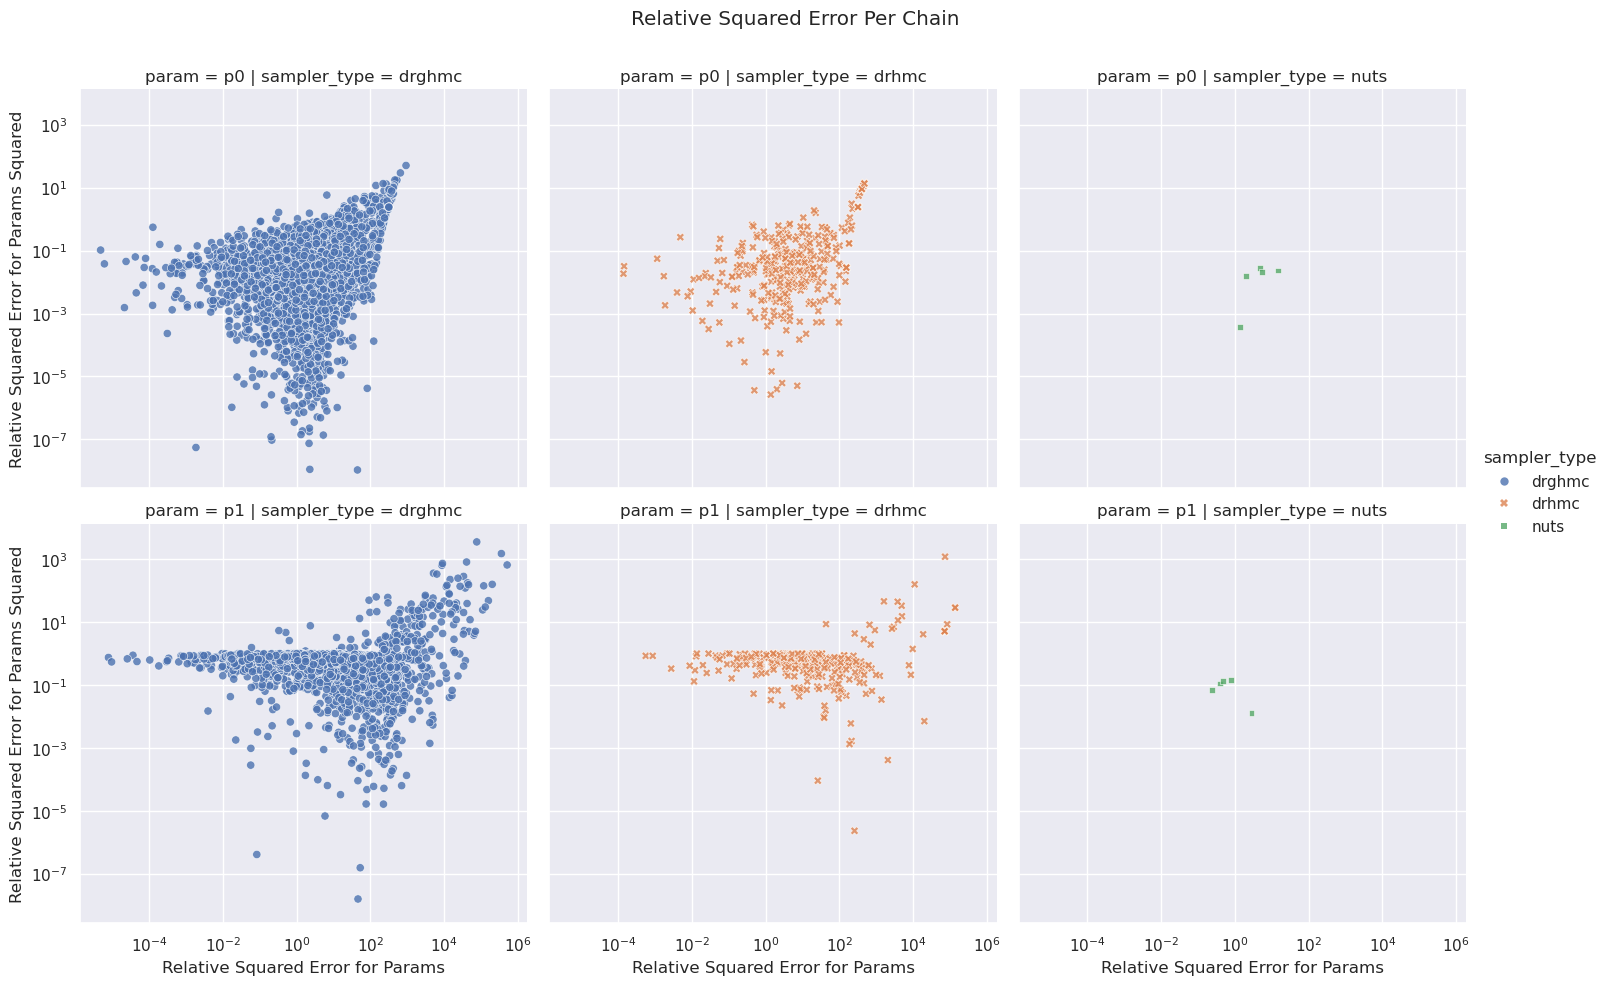

In [164]:
fig = sns.relplot(
    data=melted.to_pandas(),
    kind="scatter",
    x="rse1",
    y="rse2",
    hue="sampler_type",
    style="sampler_type",
    alpha=0.8,
    row="param",
    row_order=["p0", "p1"],
    col="sampler_type",
    col_order=["drghmc", "drhmc", "nuts"]
)
# rename x axis and y axis
fig.set(xlabel="Relative Squared Error for Params", ylabel="Relative Squared Error for Params Squared")
fig.set(xscale="log", yscale="log")
fig.fig.subplots_adjust(top = 0.9)
fig.fig.suptitle("Relative Squared Error Per Chain")

In [165]:
melted_group = melted.group_by("param", "hparams").agg([
    pl.col("rse1").std().alias("rse1_std"),
    pl.col("rse2").std().alias("rse2_std"),
    pl.col("rse1").mean().alias("rse1_mean"),
    pl.col("rse2").mean().alias("rse2_mean"),
    pl.col("sampler_type").first().alias("sampler_type"),
    #pl.col("step_count_method").first().alias("step_count_method"),
    # pl.col("step_count_factor").first().alias("step_count_factor"),
    # pl.col("max_proposals").first().alias("max_proposals"),
    # pl.col("reduction_factor").first().alias("reduction_factor"),
    # pl.col("damping").first().alias("damping"),
])

# make new Polars column for the max of se1_std and se2_std 
melted_group = melted_group.with_columns(
    pl.when(pl.col("rse1_std") > pl.col("rse2_std")).then(pl.col("rse1_std")).otherwise(pl.col("rse2_std")).alias("max_std")
)
melted_group.describe()

statistic,param,hparams,rse1_std,rse2_std,rse1_mean,rse2_mean,sampler_type,max_std
str,str,str,f64,f64,f64,f64,str,f64
"""count""","""1762""","""1762""",1762.0,1762.0,1762.0,1762.0,"""1762""",1762.0
"""null_count""","""0""","""0""",0.0,0.0,0.0,0.0,"""0""",0.0
"""mean""",null,null,1248.291079,3.910087,581.646396,2.036275,null,1248.291573
"""std""",null,null,8604.110336,46.275966,3882.883778,20.735915,null,8604.110264
"""min""","""p0""","""damping=0.01__…",0.055182,0.000848,0.087741,0.00111,"""drghmc""",0.055182
"""25%""",null,null,2.850841,0.046767,3.134163,0.040076,null,2.850841
"""50%""",null,null,13.010603,0.185639,11.905485,0.416434,null,13.010603
"""75%""",null,null,112.112599,0.358342,64.52722,0.67504,null,112.112599
"""max""","""p1""","""sampler_type=n…",226475.019124,1583.648681,101306.904417,708.722551,"""nuts""",226475.019124


/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, 'Relative Squared Error Per Hyperparameter Configuration')

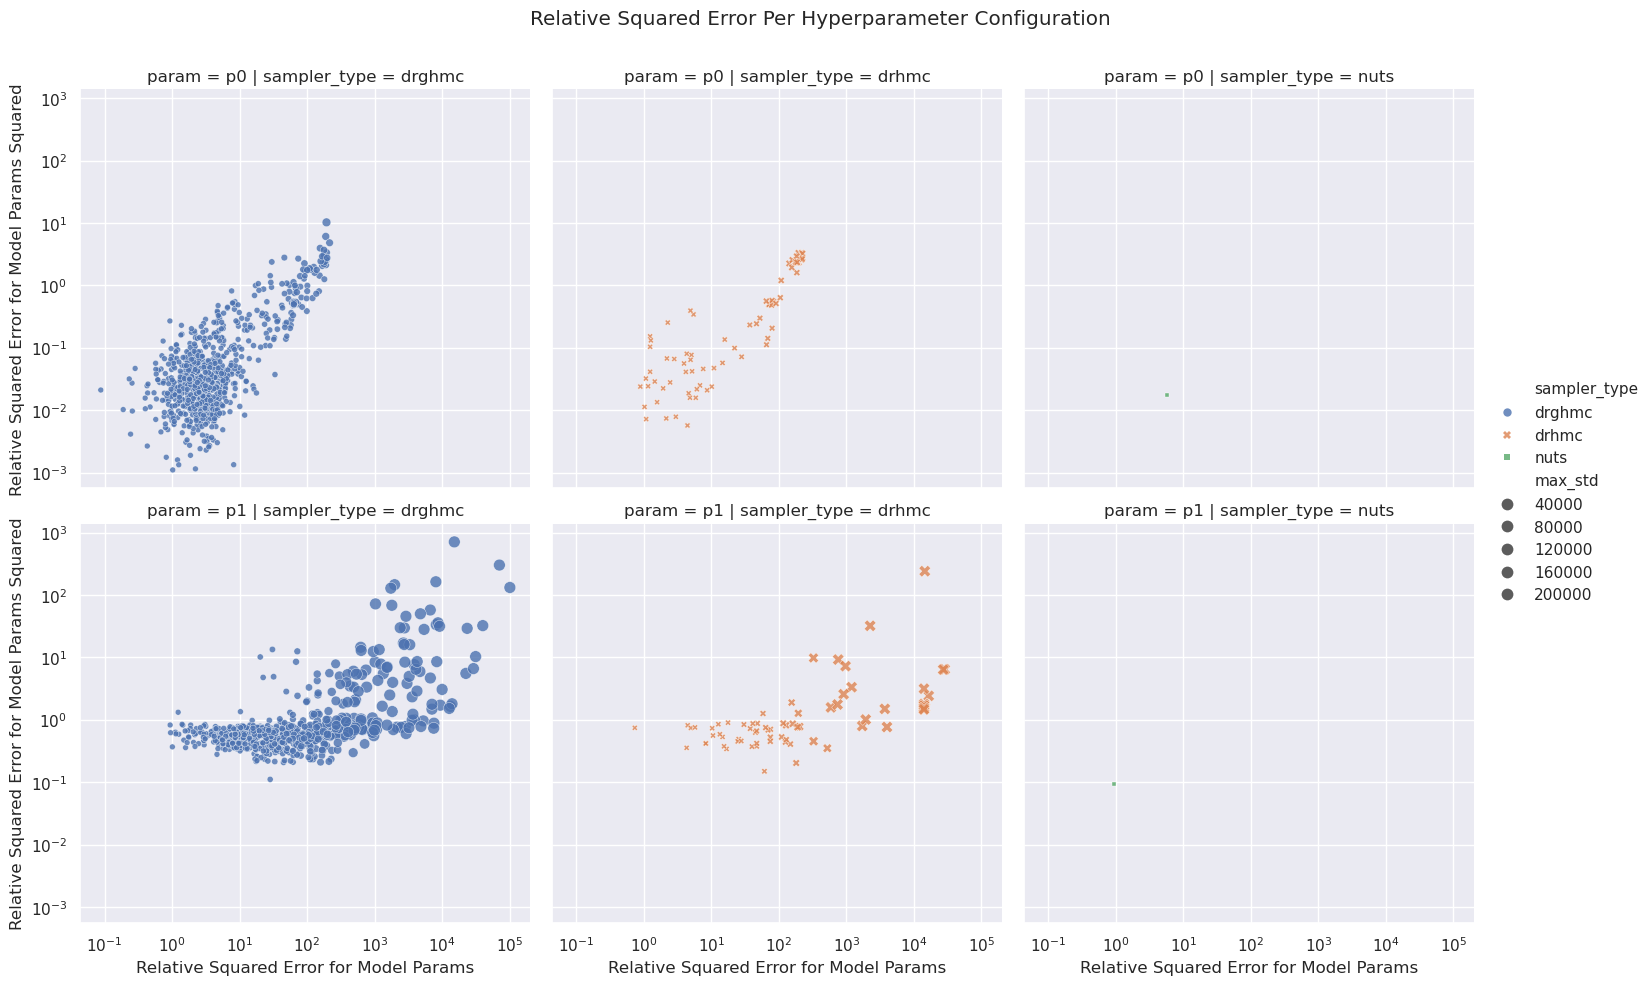

In [171]:
fig = sns.relplot(
    data=melted_group.to_pandas(),
    kind="scatter",
    x="rse1_mean",
    y="rse2_mean",
    hue="sampler_type",
    style="sampler_type",
    alpha=0.8,
    col="sampler_type",
    col_order=["drghmc", "drhmc", "nuts"],
    row="param",
    row_order=["p0", "p1"],
    size="max_std",
    size_norm=(1, 1000),
    legend="brief",
)
# rename x axis and y axis
fig.set(xlabel="Relative Squared Error for Model Params", ylabel="Relative Squared Error for Model Params Squared")
fig.set(xscale="log", yscale="log")
fig.fig.subplots_adjust(top = 0.9)
fig.fig.suptitle("Relative Squared Error Per Hyperparameter Configuration")

# Squared Error vs Gradient Evaluations

In [4]:
# summary = get(dataframe=summary, metrics=["max_se1"], history=["grad_evals"])

In [38]:
summary = summary.sort("p1_se2")
# get hparams with the lowest max_se1
best_hparams = summary.select("hparams")
# print the entire Polars dataframe, making sure the columns are not truncated
print(best_hparams.to_pandas().to_string())

                                                                                                                                                                                hparams
0         damping=0.05__max_proposals=3__metric=1__probabilistic=False__reduction_factor=4__sampler_type=drghmc__step_count_method=const_step_count__step_size=None__step_size_factor=5
1        damping=0.5__max_proposals=2__metric=1__probabilistic=False__reduction_factor=16__sampler_type=drghmc__step_count_method=const_traj_length__step_size=None__step_size_factor=5
2        damping=0.05__max_proposals=5__metric=1__probabilistic=False__reduction_factor=4__sampler_type=drghmc__step_count_method=const_traj_length__step_size=None__step_size_factor=1
3         damping=0.3__max_proposals=2__metric=1__probabilistic=False__reduction_factor=16__sampler_type=drghmc__step_count_method=const_step_count__step_size=None__step_size_factor=2
4       damping=0.01__max_proposals=4__metric=1__probabilistic=False__reduction_

In [68]:
def get_df(param_str="sampler_type=nuts__seed=1234__burn_in=0__gradient_budget=1000000"):
    
    to_vstack = []
    for idx in range(5):
        to_hstack = []
        # fname = f"burn_in=0__chain={idx}__gradient_budget=1000000__sampler_type=nuts__seed=1234"

        # fname = f"burn_in=0__chain={idx}__damping=1__gradient_budget=1000000__max_proposals=3__metric=1__probabilistic=False__reduction_factor=4__sampler_type=drhmc__seed=1234__step_count=None__step_count_factor=0.9__step_size=None__step_size_factor=2"
        
        fname = f"burn_in=0__chain={idx}__damping=0.05__gradient_budget=1000000__max_proposals=4__metric=1__probabilistic=False__reduction_factor=4__sampler_type=drghmc__seed=1234__step_count_method=const_step_count__step_size=None__step_size_factor=2"

        
        history_path = os.path.join(data_dir, fname, "history.npz")
        history_np = np.load(history_path)
        metrics_path = os.path.join(data_dir, fname, "metrics.npz")
        metrics_np = np.load(metrics_path)

        to_hstack.append(history_np["grad_evals"].round(-4))
        to_hstack.append(history_np["draws"][:, 0])
        to_hstack.append(history_np["draws"][:, 1])
        to_hstack.append(history_np["draws"][:, 2])
        to_hstack.append(metrics_np["max_se1"])
        to_hstack.append(metrics_np["max_se2"])
        to_hstack.append(np.array([idx] * len(history_np["grad_evals"])))
        to_hstack.append(np.array(["nuts"] * len(history_np["grad_evals"])))
        to_hstack.append(metrics_np["se1"][:, 0])
        to_hstack.append(metrics_np["se2"][:, 0])
        data = np.hstack([arr.reshape(-1, 1) for arr in to_hstack])
        # data = data[::100] # thin the data at every 100th row
        to_vstack.append(data)
    
    data = np.vstack(to_vstack)
    schema = ["grad_evals", "p0", "p1", "p2", "max_se1", "max_se2", "chain", "sampler_type", "p0_se1", "p0_se2"]
    df = pl.from_numpy(data=data, schema=schema)
    
    df = df.with_columns(
        pl.col("grad_evals").cast(pl.Float64),
        pl.col("p0").cast(pl.Float64),
        pl.col("p1").cast(pl.Float64),
        pl.col("p2").cast(pl.Float64),
        pl.col("max_se1").cast(pl.Float64),
        pl.col("max_se2").cast(pl.Float64),
        pl.col("chain").cast(pl.UInt32),
        pl.col("p0_se1").cast(pl.Float64),
        pl.col("p0_se2").cast(pl.Float64),
    )
    
    return df
    
squared_error = get_df()
squared_error.tail()

grad_evals,p0,p1,p2,max_se1,max_se2,chain,sampler_type,p0_se1,p0_se2
f64,f64,f64,f64,f64,f64,u32,str,f64,f64
1e6,1.516803,1.30528,1.016639,0.027596,7755.058324,4,"""nuts""",0.009986,1.880349
1e6,0.892211,1.620975,0.493425,0.027596,7755.061771,4,"""nuts""",0.009985,1.880389
1e6,0.892211,1.620975,0.493425,0.027595,7755.065219,4,"""nuts""",0.009985,1.88043
1e6,1.546759,1.212201,1.135662,0.027594,7755.067561,4,"""nuts""",0.009984,1.880461
1e6,1.546759,1.212201,1.135662,0.027593,7755.069903,4,"""nuts""",0.009984,1.880492


/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, '[DR-GHMC P0] Squared Error vs Gradient Evaluations')

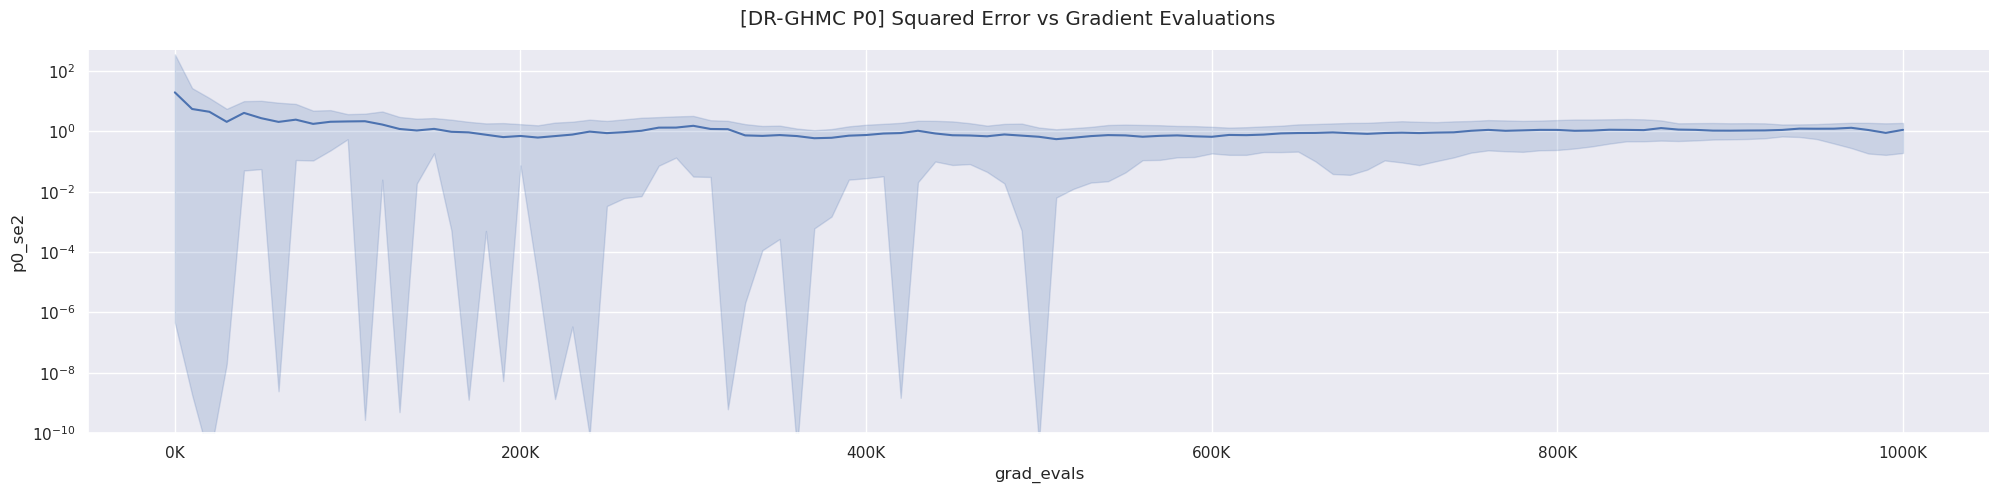

In [70]:
fig = sns.relplot(
    data=squared_error.to_pandas(),
    kind="line",
    x="grad_evals",
    y="p0_se2",
    # hue="chain",
    # units="chain",
    # estimator=None,
    errorbar=lambda x: (x.min(), x.max()),
    aspect=4,
)
fig.set(yscale="log")
fig.set(xticks=[0, 200000, 400000, 600000, 800000, 1000000], xticklabels=["0K", "200K", "400K", "600K", "800K", "1000K"])
fig.set(ylim=(1e-10, 5e2))
fig.fig.subplots_adjust(top = 0.9)
fig.fig.suptitle("[DR-GHMC P0] Squared Error vs Gradient Evaluations")

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 0.98, '[NUTS] Param 0 vs Gradient Evaluations')

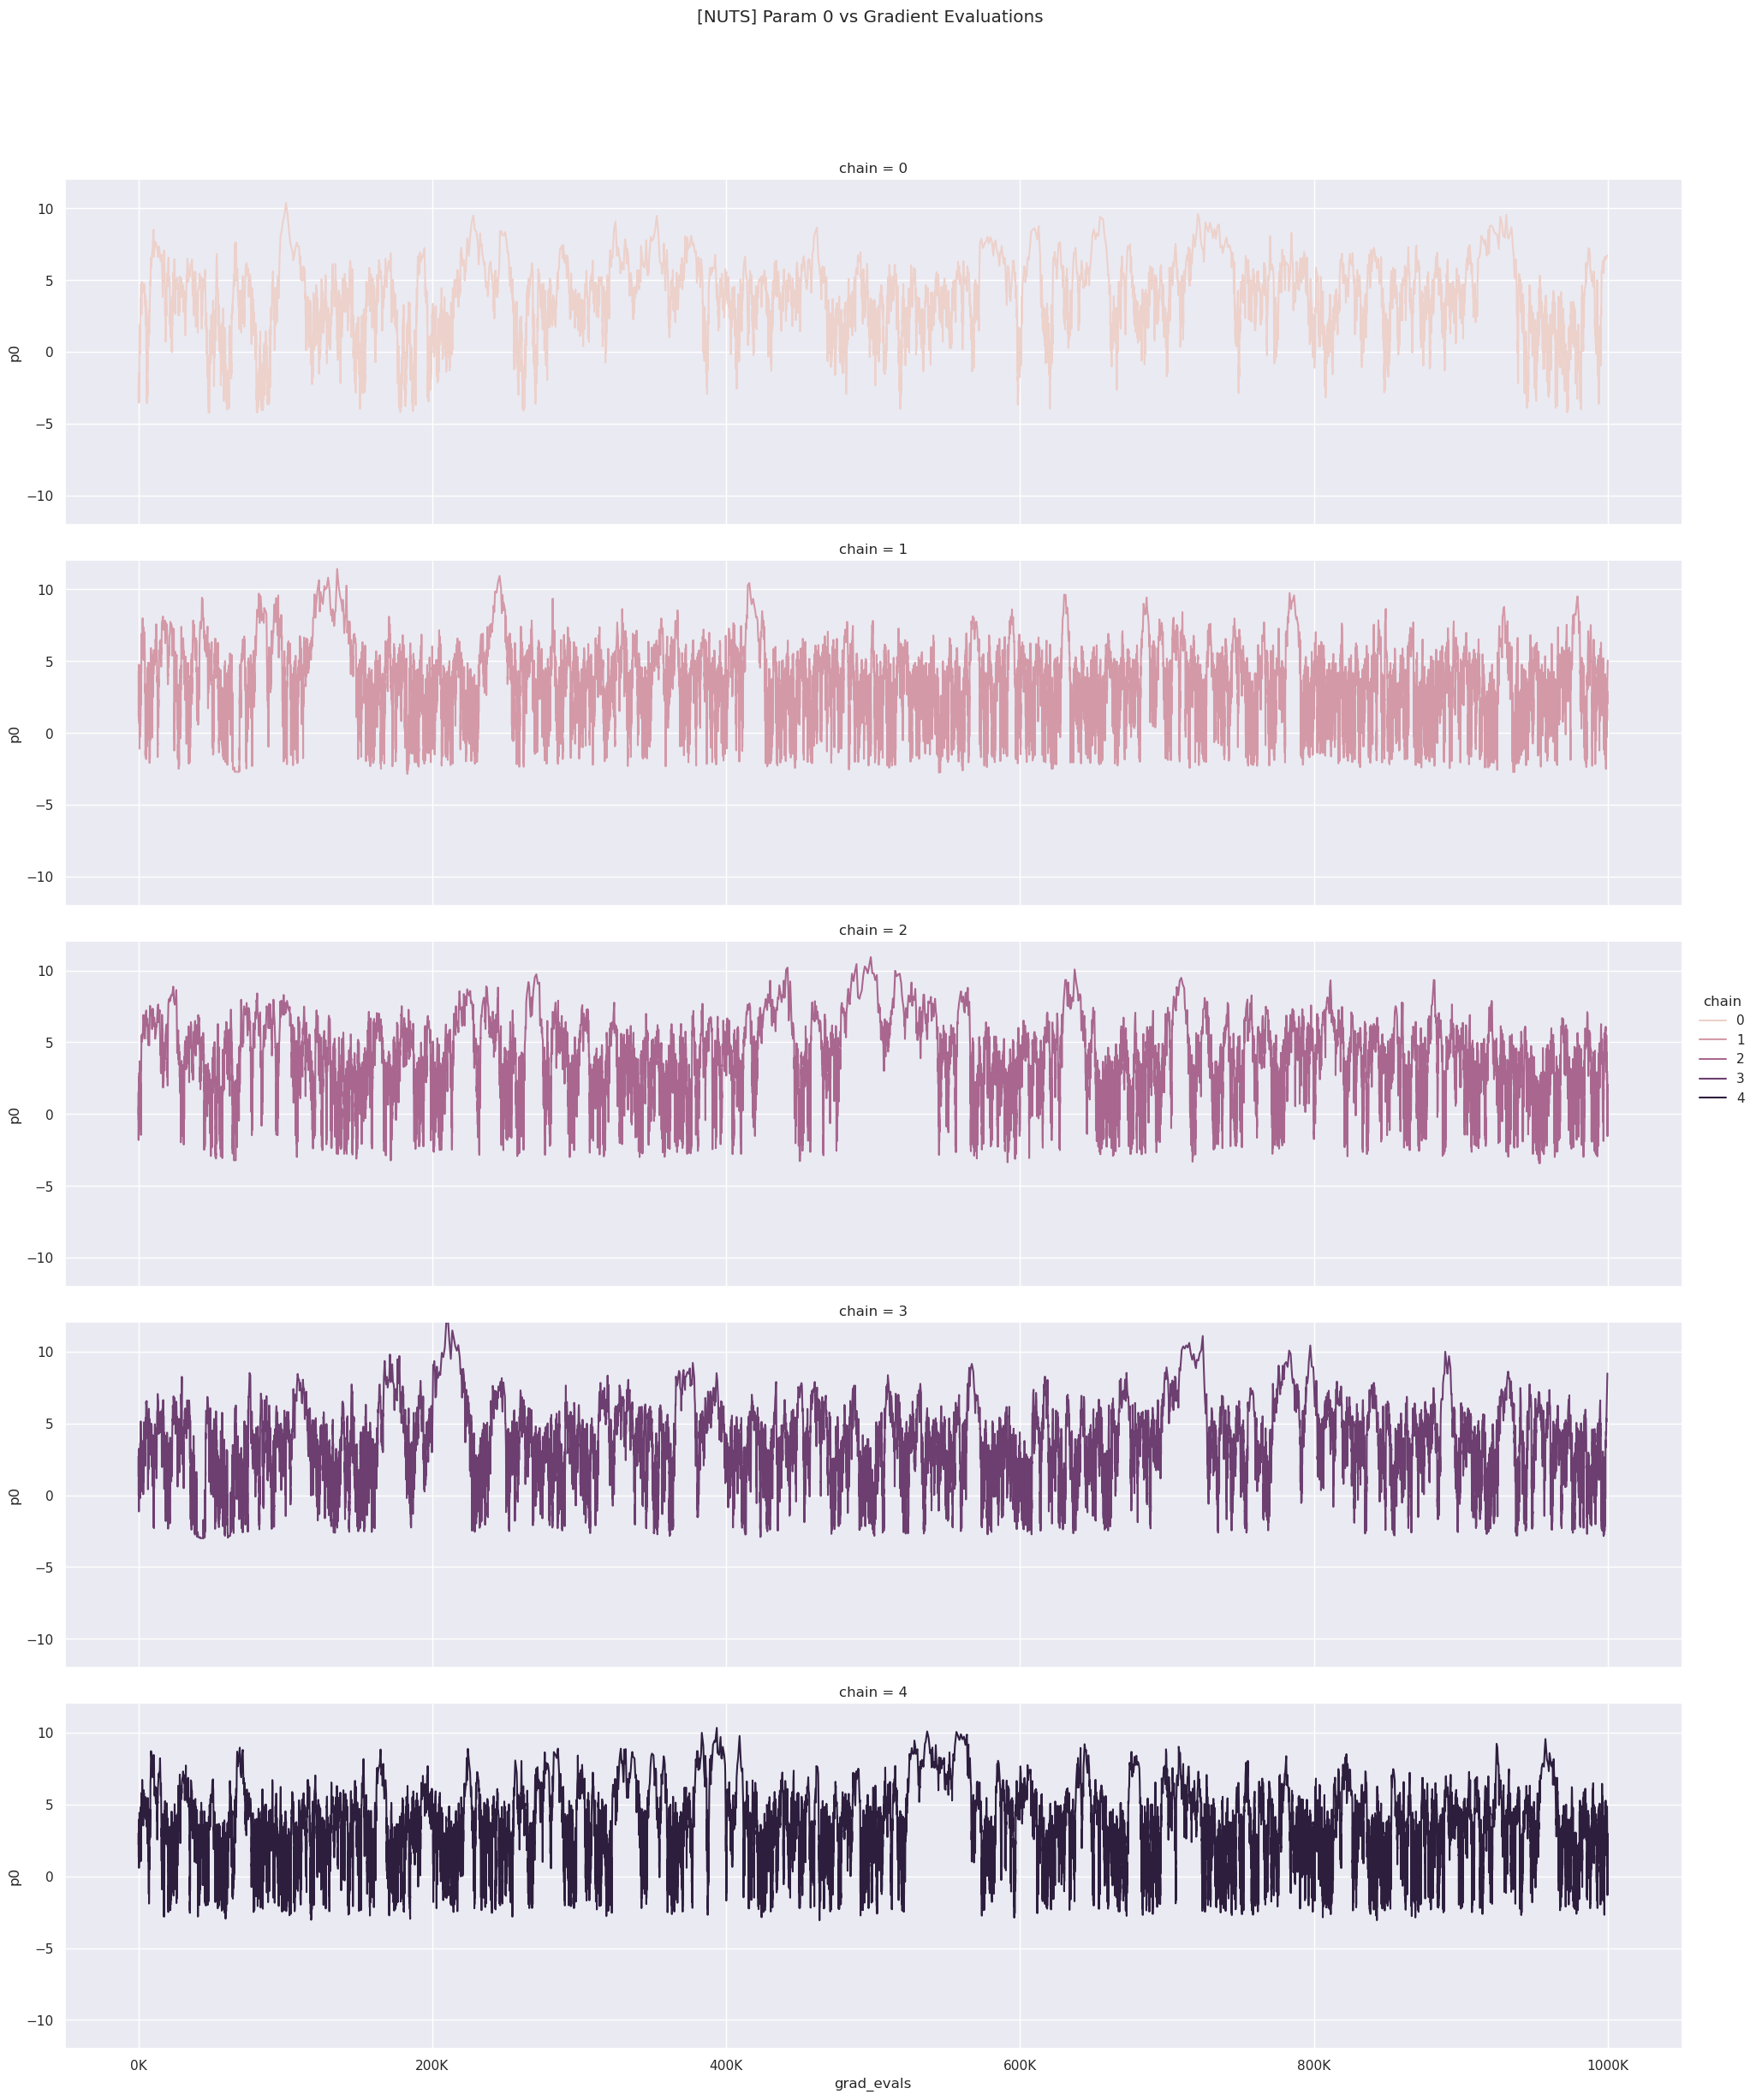

In [25]:
fig = sns.relplot(
    data=squared_error.to_pandas(),
    kind="line",
    x="grad_evals",
    y="p0",
    hue="chain",
    units="chain",
    col="chain",
    col_wrap=1,
    estimator=None,
    # errorbar=lambda x: (x.min(), x.max()),
    aspect=4,
)

fig.set(xticks=[0, 200000, 400000, 600000, 800000, 1000000], xticklabels=["0K", "200K", "400K", "600K", "800K", "1000K"])
fig.set(ylim=(-12, 12))
fig.fig.subplots_adjust(top = 0.9)
fig.fig.suptitle("[NUTS] Param 0 vs Gradient Evaluations")

/mnt/home/gturok/mambaforge/envs/drghmc/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


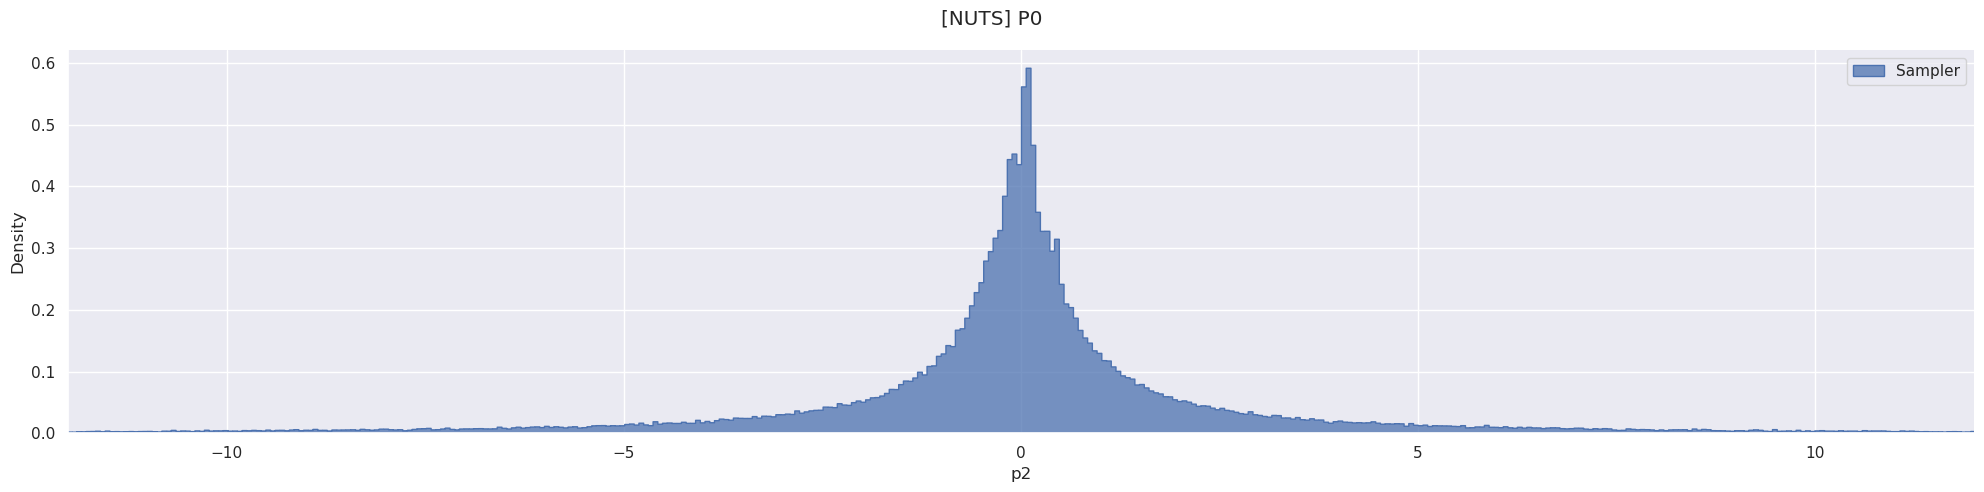

In [22]:
fig = sns.displot(
    data=squared_error.to_pandas(),
    kind="hist",
    x="p2",
    # hue="chain",
    aspect=4,
    stat="density",
    element="step",
    common_norm=False,
)

fig.set(xlim=(-12, 12))
fig.fig.subplots_adjust(top = 0.9)
fig.fig.suptitle("[NUTS] P0")

# add kds for normal(0, 3) distribution
# x = np.linspace(-12, 12, 100)
# y = stats.norm.pdf(x, 0, 3)
# fig.ax.plot(x, y, color="black")

fig.ax.legend(["Sampler", "Reference Draws"])